# Lung Cancer Survival Prediction with Synthetic Data
Supervisor: Markus Haug, University of Tartu  
Team: Henry Marie MONT, Jean-Côme CARISSAN  

## Objective:
Utilize synthetic medical data to predict 5-year survival rates post-lung cancer diagnosis by effectively selecting key features from patient treatment trajectories.  
  
## Outcome:
A workflow that, given patient treatment trajectory data, outputs a 5-year survival prediction. The said workflow will be tested on a test set not seen by students and compared with other groups work.  
  
## Import

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectKBest, mutual_info_regression

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

## Data opening

In [38]:
file_path = './data/synthetic_data_lung_cancer.csv'
df = pd.read_csv(file_path)

df.head()

,SUBJECT_ID,DEFINITION_ID,TIME
0,1,drug_217,0.004807
1,1,condition_1922,0.008643
2,1,condition_785,0.027792
3,1,drug_49,0.032515
4,1,measurement_132,0.056765


## Data pruning

In [39]:
# # Using a smaller subset for performance issues
# subset_fraction = 0.3
# df = df.sample(frac=subset_fraction, random_state=42)

## Data cleaning

In [40]:
# # Handle Missing Values
# df.isnull().sum()  # Check for missing values
# df = df.dropna()    # Drop rows with missing values

# # Identify and Remove Outliers (assuming 'TIME' is a numerical column)
# Q1 = df['TIME'].quantile(0.25)
# Q3 = df['TIME'].quantile(0.75)
# IQR = Q3 - Q1

# # Define upper and lower bounds for outliers
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# # Remove outliers
# df = df[(df['TIME'] >= lower_bound) & (df['TIME'] <= upper_bound)]

# # Display basic statistics after data cleaning
# print("\nSummary Statistics after Data Cleaning:")
# print(df.describe())

## Feature engineering

In [41]:
# Build the target feature ('DIED')
df['DIED'] = 0

# Identify rows where the "death" state is present
death_rows = df[df['DEFINITION_ID'].str.lower() == 'death']

# Iterate through each death row and update DIED column for corresponding rows
for _, death_row in death_rows.iterrows():
    patient_id = death_row['SUBJECT_ID']
    death_time = death_row['TIME']
    
    if death_time < 5:
        # Update DIED to 1 for rows with the same PATIENT_ID and TIME within 1 year
        df.loc[(df['SUBJECT_ID'] == patient_id), 'DIED'] = 1

# Delete the rows indicating death as that is what we are trying to predict
df = df[df['DEFINITION_ID'].str.lower() != 'death']

df.head()

,SUBJECT_ID,DEFINITION_ID,TIME,DIED
146286,251,drug_167,4.085872,0
522409,898,measurement_562,7.724991,0
314621,518,measurement_1113,7.005983,0
397520,658,measurement_1257,6.831718,0
377685,635,measurement_966,0.894524,0


In [42]:
# Keep time but proceed to bining and merging with 'DEFINITION_ID' features
# Allow us to retain more information about the timeframe in which the procedure happened
# df['TIME'] = np.floor(df['TIME']).astype(int)
# df['DEFINITION_ID'] = df['DEFINITION_ID'] + '_' + df['TIME'].astype(str)

# Drop 'TIME' to focus on 'DEFINITION_ID'
df= df.drop(['TIME'], axis=1)

df.head()

,SUBJECT_ID,DEFINITION_ID,DIED
146286,251,drug_167,0
522409,898,measurement_562,0
314621,518,measurement_1113,0
397520,658,measurement_1257,0
377685,635,measurement_966,0


In [43]:

# Proceed to one-hot encode and group together all interventions happening on one patient
# One-hot encode the 'DEFINITION_ID' feature
df = pd.get_dummies(df, columns=['DEFINITION_ID'], prefix='DEF')
# Group by 'SUBJECT_ID' and perform a logical OR on 'DIED'
df = df.groupby('SUBJECT_ID').max()

df.head()

,DIED,DEF_condition_1,DEF_condition_10,DEF_condition_100,DEF_condition_1000,DEF_condition_1001,DEF_condition_1002,DEF_condition_1003,DEF_condition_1004,DEF_condition_1005,...,DEF_procedure_90,DEF_procedure_91,DEF_procedure_92,DEF_procedure_93,DEF_procedure_94,DEF_procedure_95,DEF_procedure_96,DEF_procedure_97,DEF_procedure_98,DEF_procedure_99
SUBJECT_ID,,,,,,,,,,,,,,,,,,,,,
1,0,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,0,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
4,0,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6,0,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Data formating

In [44]:
# Separate features and target variable
X = df.drop(['DIED'], axis=1)
y = df['DIED']

## Feature selection

[4.93136456e-02 1.86660347e-02 1.76580347e-02 1.21751411e-02
 1.08809771e-02 1.00353401e-02 8.25951704e-03 7.70419608e-03
 7.15910029e-03 6.66962216e-03 6.25700904e-03 6.08285562e-03
 5.76812606e-03 5.47292717e-03 5.31834358e-03 5.15579195e-03
 5.08234175e-03 4.98618232e-03 4.94393632e-03 4.89280891e-03
 4.79166358e-03 4.63286646e-03 4.57944875e-03 4.46747080e-03
 4.43640069e-03 4.41136154e-03 4.34639050e-03 4.33167292e-03
 4.30858077e-03 4.24647701e-03 4.14396453e-03 4.08414572e-03
 4.06987809e-03 3.99331643e-03 3.97115902e-03 3.94752943e-03
 3.87555726e-03 3.84402264e-03 3.83287580e-03 3.75964595e-03
 3.73903889e-03 3.71401059e-03 3.68010516e-03 3.65314717e-03
 3.64257321e-03 3.63043138e-03 3.59265675e-03 3.55159115e-03
 3.53323034e-03 3.50181331e-03 3.48292331e-03 3.45662183e-03
 3.42914979e-03 3.41543718e-03 3.39985744e-03 3.37951361e-03
 3.34638929e-03 3.33664547e-03 3.32217443e-03 3.29923881e-03
 3.29000001e-03 3.28076230e-03 3.24582184e-03 3.22326403e-03
 3.21026639e-03 3.198283

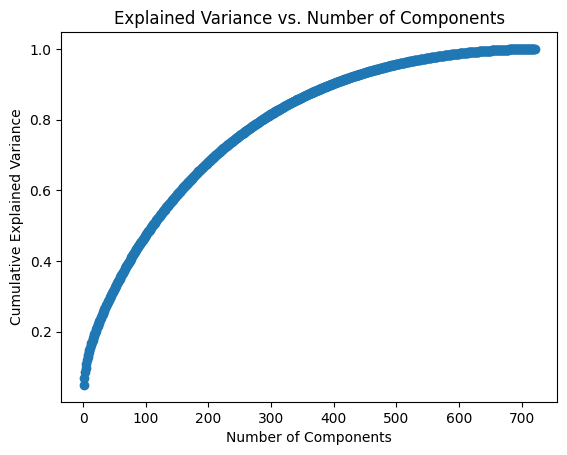

In [45]:
# PCA
# Standardize the features (important for PCA)
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

# Apply PCA
num_components = min(X.shape[0], X.shape[1])
pca = PCA(n_components=num_components)
X_pca = pca.fit_transform(X_standardized)

# Print the explained variance ratio for each component
explained_variance_ratio = pca.explained_variance_ratio_
# print("Explained Variance Ratio:")
print(explained_variance_ratio)

# Compute and display cumulative explained variance
# Here it seem the sweet spot is between 40 and 120 features
cumulative_variance = np.cumsum(explained_variance_ratio)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.show()

# Select the desired number of components based on the explained variance
desired_num_components = 50  # Change this as needed
selected_components = X_pca[:, :desired_num_components]

# Create a DataFrame with the selected components and target variable
pca_selected = pd.DataFrame(selected_components, columns=[f'PC{i+1}' for i in range(desired_num_components)])
pca_selected['DIED'] = y.values

## Data formating

In [46]:
# Separate features and target variable
X_tweaked = pca_selected.drop(['DIED'], axis=1)
y_tweaked = pca_selected['DIED']
X_train, X_test, y_train, y_test = train_test_split(X_tweaked, y_tweaked, test_size=0.2, random_state=42)

## Training

In [47]:
# Initialize individual models
gb = GradientBoostingClassifier(learning_rate=0.05, max_depth=5, n_estimators=100)
xgb = XGBClassifier(learning_rate=0.2, max_depth=5, n_estimators=200)
rf = RandomForestClassifier(max_depth=20, min_samples_split=5, n_estimators=200)
svm = SVC(C=0.1, gamma='scale', kernel='rbf', probability=True)

# Create an ensemble using VotingClassifier
ensemble = VotingClassifier(estimators=[
    ('gb', gb),
    ('xgb', xgb),
    ('rf', rf),
    ('svm', svm)
], voting='soft')  # 'soft' for averaging predicted probabilities

# Fit the ensemble model on the training data
ensemble.fit(X_train, y_train)

# Predict probabilities on the test set
y_pred_ensemble = ensemble.predict_proba(X_test)[:, 1]

## Evaluating model

In [48]:
# Evaluate AUC-ROC on the test set
auc_ensemble = roc_auc_score(y_test, y_pred_ensemble)
print("Ensemble AUC-ROC on Test Set:", auc_ensemble)

Ensemble AUC-ROC on Test Set: 0.6952614379084967
